# VishwamAI Model Architecture Analysis

This notebook analyzes the architecture and components of the VishwamAI transformer model implementation.

In [1]:
# Import required libraries
import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import matplotlib.pyplot as plt
import time
from typing import Dict, List, Tuple

from vishwamai.model import VishwamAI
from vishwamai.kernels.kernel import fp8_gemm_optimized
from vishwamai.layers.attention import FlashAttention
from vishwamai.transformer import (
    TransformerModel,
    EnhancedTransformerModel,
    create_vishwamai_transformer
)

2025-03-19 13:17:39.089887: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742370459.109501   15430 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742370459.116065   15430 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Model Architecture Overview

VishwamAI implements a transformer architecture with several key optimizations:

1. TPU-optimized components
2. Mixed precision training support
3. Flash Attention implementation
4. Optional RMSNorm for better performance
5. Rotary position embeddings

The model consists of these main components:

- Token Embeddings
- Position Embeddings (optional if using rotary)
- Transformer Blocks:
  - Multi-head Self Attention
  - Feed Forward Network
  - Layer Normalization
- Output Layer

In [2]:
def create_sample_config():
    return {
        'vocab_size': 32000,
        'num_layers': 12,
        'num_heads': 12,
        'head_dim': 64,
        'hidden_dim': 768,
        'mlp_dim': 3072,
        'max_seq_len': 2048,
        'dropout_rate': 0.1,
        'use_enhanced': True,
        'use_rotary': True,
        'use_flash_attn': True,
        'use_rms_norm': False
    }

## Model Components Analysis

### Enhanced Transformer Block

The enhanced transformer block implements:

1. Pre-normalization architecture
2. Flash Attention for efficient attention computation
3. SwiGLU activation in FFN
4. Optional RMSNorm
5. Rotary position embeddings

In [3]:
def analyze_model_size(config):
    """Calculate model size and component breakdown"""
    vocab_size = config['vocab_size']
    hidden_dim = config['hidden_dim']
    num_layers = config['num_layers']
    mlp_dim = config['mlp_dim']
    
    embedding_params = vocab_size * hidden_dim
    attention_params = num_layers * (4 * hidden_dim * hidden_dim)
    ffn_params = num_layers * (2 * hidden_dim * mlp_dim)
    layer_norm_params = num_layers * 2 * hidden_dim
    
    total_params = embedding_params + attention_params + ffn_params + layer_norm_params
    
    return {
        'total': total_params,
        'embedding': embedding_params,
        'attention': attention_params,
        'ffn': ffn_params,
        'layer_norm': layer_norm_params
    }

(-1.0999997272710962,
 1.0999999870129094,
 -1.0999999186101608,
 1.0999994913588562)

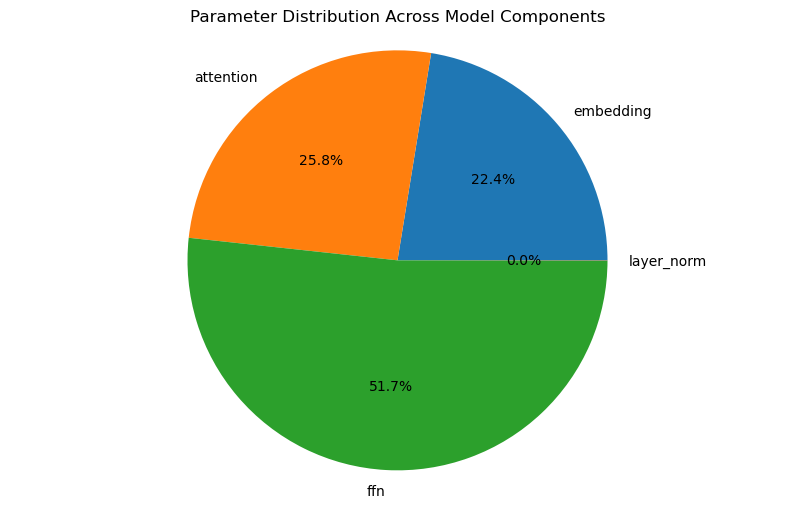

In [4]:
# Analyze model architecture
config = create_sample_config()
model_stats = analyze_model_size(config)

# Plot parameter distribution
plt.figure(figsize=(10, 6))
plt.pie([v/model_stats['total'] for v in model_stats.values()][1:],
        labels=[k for k in model_stats.keys()][1:],
        autopct='%1.1f%%')
plt.title('Parameter Distribution Across Model Components')
plt.axis('equal')

## TPU Optimizations

Key TPU optimizations in VishwamAI:

1. Optimized GEMM operations using TPUGEMMLinear
2. Memory-efficient attention with Flash Attention
3. Optimal data types (bfloat16 for compute, float32 for accumulation)
4. Efficient layer normalization implementations
5. Memory-bandwidth optimized position embeddings

In [5]:
# Initialize model
model = create_vishwamai_transformer(config)

# Print model summary
print(f"Total Parameters: {model_stats['total']:,}")
print(f"Hidden Dimension: {config['hidden_dim']}")
print(f"Number of Layers: {config['num_layers']}")
print(f"Number of Attention Heads: {config['num_heads']}")
print(f"Maximum Sequence Length: {config['max_seq_len']}")

Total Parameters: 109,529,088
Hidden Dimension: 768
Number of Layers: 12
Number of Attention Heads: 12
Maximum Sequence Length: 2048
